In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
import cv2
import numpy as np
import random
import os
import pandas as pd
import warnings
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Activation, Multiply, Reshape,
    GlobalAveragePooling2D, Dense, AveragePooling2D, Lambda, BatchNormalization
)
from tensorflow.keras.models import Model

C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    directory=r"D:\Akshaya\Resampled prostate images with reduced images - Copy\train",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=r"D:\Akshaya\Resampled prostate images with reduced images - Copy\Valid",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    directory=r"D:\Akshaya\Resampled prostate images with reduced images - Copy\test",
    target_size=(256, 256),
    batch_size=16,
    shuffle=False  
)


def bchisto_wrapper(generator):
    while True:
        X, y = next(generator)

        yield (
            {'global_input': X, 'local_input': X},  
            {
                'main_output': y,
                'global_output': y,
                'local_output': y
            }
        )
train_gen = bchisto_wrapper(train_generator)
val_gen   = bchisto_wrapper(val_generator)
test_gen= bchisto_wrapper(test_generator)
print("Train classes:", train_gen)
print("Validation classes:", val_gen)
print("Test classes:", test_gen)

Found 11684 images belonging to 4 classes.
Found 2939 images belonging to 4 classes.
Found 2854 images belonging to 4 classes.
Train classes: <generator object bchisto_wrapper at 0x00000228F67B6580>
Validation classes: <generator object bchisto_wrapper at 0x00000228F6809A50>
Test classes: <generator object bchisto_wrapper at 0x00000228F6809190>


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

def inception_module(x):

    conv1 = layers.Conv2D(64, (1, 1), padding="same", activation="relu")(x)
    conv3 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    conv5 = layers.Conv2D(64, (5, 5), padding="same", activation="relu")(x)

    pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding="same")(x)
    pool_conv = layers.Conv2D(64, (1, 1), padding="same", activation="relu")(pool)

    return layers.Concatenate(axis=-1)([conv1, conv3, conv5])

def build_feature_extractor(input_tensor, name_prefix):
    """Identical for both Global and Local branches [cite: 178]"""
    x = inception_module(input_tensor)
    
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
        
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    return x

def build_bchisto_net(input_shape=(256, 256, 3)):

    img_global = Input(shape=input_shape, name="global_input")
    img_local = Input(shape=input_shape, name="local_input")


    feat_global = build_feature_extractor(img_global, "global")
    gap_global = layers.GlobalAveragePooling2D()(feat_global)
    aux_global = layers.Dense(4, activation='sigmoid', name='global_output')(gap_global)

    feat_local = build_feature_extractor(img_local, "local")
    gap_local = layers.GlobalAveragePooling2D()(feat_local)
    aux_local = layers.Dense(4, activation='sigmoid', name='local_output')(gap_local)


    f_g = layers.GlobalAveragePooling2D()(feat_global)
    f_l = layers.GlobalAveragePooling2D()(feat_local)
    f_ag = layers.Add()([f_g, f_l])


    x = layers.Dense(4024, activation='elu')(f_ag)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(4024, activation='elu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    main_output = layers.Dense(4, activation='sigmoid', name='main_output')(x)

    model = models.Model(inputs=[img_global, img_local], 
                         outputs=[main_output, aux_global, aux_local])
    return model

model = build_bchisto_net()
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
global_input (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
local_input (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_422 (Conv2D)             (None, 256, 256, 64) 256         global_input[0][0]               
__________________________________________________________________________________________________
conv2d_423 (Conv2D)             (None, 256, 256, 64) 1792        global_input[0][0]               
___________________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam
model = build_bchisto_net()

opt = Adam(learning_rate=0.001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        'main_output': 'categorical_crossentropy',
        'global_output': 'categorical_crossentropy',
        'local_output': 'categorical_crossentropy'
    },
    loss_weights={
        'main_output': 1.0,
        'global_output': 0.3,
        'local_output': 0.3
    },
    metrics={'main_output': 'accuracy'}
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.5,
    patience=5,
    verbose=1,
    min_delta=0.0001
)

 
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=30,
    verbose=1,
    mode='max',
    restore_best_weights=True
)


check_path = '/content/drive/MyDrive/BHC net.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    check_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)


history= model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=65,
    callbacks=[reduce_lr, early_stop, checkpoint]
)



Epoch 1/65
731/731 [==============================] - 757s 1s/step - loss: 1.8232 - main_output_loss: 1.3585 - global_output_loss: 0.7754 - local_output_loss: 0.7734 - main_output_accuracy: 0.6090 - val_loss: 1.5221 - val_main_output_loss: 0.8724 - val_global_output_loss: 0.9044 - val_local_output_loss: 1.2612 - val_main_output_accuracy: 0.6199
Epoch 2/65
731/731 [==============================] - 739s 1s/step - loss: 1.2366 - main_output_loss: 0.8610 - global_output_loss: 0.6171 - local_output_loss: 0.6349 - main_output_accuracy: 0.6844 - val_loss: 1.5800 - val_main_output_loss: 0.9198 - val_global_output_loss: 1.2832 - val_local_output_loss: 0.9175 - val_main_output_accuracy: 0.6349
Epoch 3/65
731/731 [==============================] - 738s 1s/step - loss: 1.0225 - main_output_loss: 0.6950 - global_output_loss: 0.5248 - local_output_loss: 0.5667 - main_output_accuracy: 0.7416 - val_loss: 4.0340 - val_main_output_loss: 2.7012 - val_global_output_loss: 2.6945 - val_local_output_loss: 1

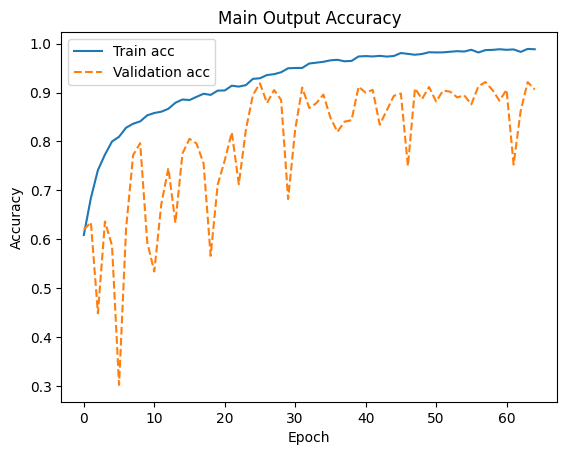

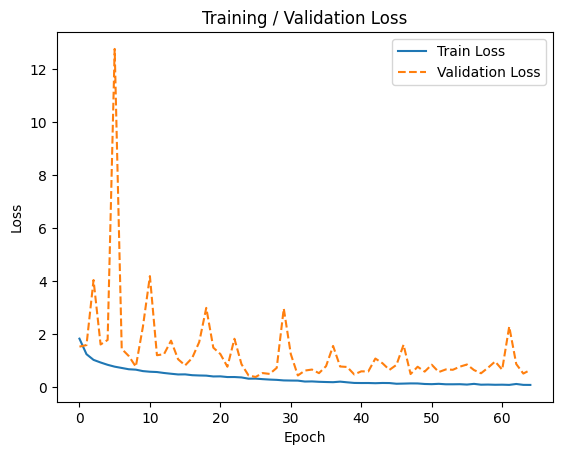

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['main_output_accuracy'])
plt.plot(history.history['val_main_output_accuracy'], '--')
plt.legend(['Train acc', 'Validation acc'])
plt.title('Main Output Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '--')
plt.legend(['Train Loss', 'Validation Loss'])
plt.title('Training / Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# vgg16model.load_weights("./cropModel.h5")
import numpy as np

y_true = test_generator.labels

Y_pred = model.predict(test_gen, steps=len(test_generator))
y_pred = np.argmax(Y_pred[0], axis=1)

print("True classes:")
print(y_true)

print("Predicted classes:")
print(y_pred)


True classes:
[0 0 0 ... 3 3 3]
Predicted classes:
[0 0 0 ... 0 0 2]


In [39]:
print('Accuracy {}'.format(accuracy_score(y_true=test_generator.labels, y_pred=y_pred)))
print('F1 {}'.format(f1_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('precision {}'.format(precision_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('recall {}'.format(recall_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('classification_report\n {}'.format(classification_report(y_true=test_generator.labels, y_pred=y_pred)))
print('\n\n')
cm = confusion_matrix(y_true=test_generator.labels, y_pred=y_pred)
print(cm)

Accuracy 0.8079887876664331
F1 0.8049968326858687
precision 0.8101674054001264
recall 0.8073550587343691
jaccard 0.6797780484815827
classification_report
               precision    recall  f1-score   support

           0       0.78      0.84      0.81       754
           1       0.80      0.62      0.70       700
           2       0.76      0.86      0.81       700
           3       0.90      0.91      0.90       700

    accuracy                           0.81      2854
   macro avg       0.81      0.81      0.80      2854
weighted avg       0.81      0.81      0.81      2854




[[634  94  24   2]
 [101 436 162   1]
 [ 20  13 602  65]
 [ 62   3   1 634]]
